In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import itertools
import statsmodels.api as sm
import warnings
import os
import sys

In [2]:
# add path
if '../..' in sys.path:
    pass
else:
    sys.path.insert(0, '../..')

from loader.greenhouse_loader import GreenhouseLoader


def load_co2_data():
    ghg_loader = GreenhouseLoader()
    cur_dir = os.getcwd()
    os.chdir('../../')
    ghg_loader.load()
    df_ghg = ghg_loader.get_data()
    os.chdir(cur_dir)
    return df_ghg

In [28]:
countries = ['EU', 'United States', 'India', 'China', 'Japan', 'Russia', 'Canada', 'Brazil']
sectors = ['Power industry', 'Buildings', 'Transport', 'Other industrial combustion', 'Other sectors']
construction_pred_emissions = pd.read_csv('../../results/buildings/emission_predictions.csv', header=0, index_col=[0])
construction_pred_emissions.index = countries
construction_pred_emissions = construction_pred_emissions.T
print('CONSTRUCTION')
print(construction_pred_emissions)

power_industry_pred_vector = pd.read_csv('../../results/power_industry/predicted_vector.csv', index_col=[0])
power_industry_pred_vector = power_industry_pred_vector.drop(0)
power_industry_pred_vector.index = construction_pred_emissions.index
print('POWER INDUSTRY')
print(power_industry_pred_vector)

mobility_pred_vector = pd.read_csv('../../results/mobility/predicted_vector.csv', index_col=[0])
mobility_pred_vector = mobility_pred_vector.rename(columns={'European Union': 'EU'})
mobility_pred_vector.index = construction_pred_emissions.index
print('MOBILITY')
print(mobility_pred_vector)

other_industries_pred_vector = pd.read_csv('../../results/other_industries/predicted_vector.csv', index_col=[0])
other_industries_pred_vector = other_industries_pred_vector.rename(columns={'European Union': 'EU'})
other_industries_pred_vector.index = construction_pred_emissions.index
print('OTHER INDUSTRIES')
print(other_industries_pred_vector)

other_sectors_pred_vector = pd.DataFrame(1, columns=countries, index=construction_pred_emissions.index)
print('OTHER SECTORS')
print(other_sectors_pred_vector)

CONSTRUCTION
                    EU  United States       India       China       Japan  \
2020-01-01  671.742808     470.902132  214.700296  747.762586  116.067338   
2020-02-01  670.773515     453.076098  216.178726  750.341081  115.898478   
2020-03-01  662.611682     460.007724  215.536927  760.413589  115.462231   
2020-04-01  645.816510     442.742652  206.922479  731.783054  117.563072   
2020-05-01  652.686976     463.783279  204.514914  749.443472  115.921925   
2020-06-01  652.626356     464.213440  203.335188  746.619488  115.996500   

                Russia     Canada     Brazil  
2020-01-01  222.273034  88.962910  35.719057  
2020-02-01  222.653458  88.399484  35.617061  
2020-03-01  217.680258  89.064831  35.855561  
2020-04-01  211.185381  89.081072  36.061982  
2020-05-01  207.728913  88.277114  35.887345  
2020-06-01  207.074710  88.050999  35.842277  
POWER INDUSTRY
            United States     China    Russia     India    Brazil    Canada  \
2020-01-01       0.68836

In [29]:
# Normalization of constructions
for country in construction_pred_emissions.columns:
    construction_pred_emissions[country] = construction_pred_emissions[country] / construction_pred_emissions[country][0]
construction_pred_vector = construction_pred_emissions
construction_pred_vector

,EU,United States,India,China,Japan,Russia,Canada,Brazil
2020-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-01,0.998557,0.962145,1.006886,1.003448,0.998545,1.001712,0.993667,0.997144
2020-03-01,0.986407,0.976865,1.003897,1.016918,0.994787,0.979337,1.001146,1.003822
2020-04-01,0.961404,0.940201,0.963774,0.978630,1.012887,0.950117,1.001328,1.009601
2020-05-01,0.971632,0.984883,0.952560,1.002248,0.998747,0.934566,0.992291,1.004711
2020-06-01,0.971542,0.985796,0.947065,0.998471,0.999390,0.931623,0.989750,1.003450


In [30]:
ghg_dict = load_co2_data()
co2_country_sector = ghg_dict['co2_country_sector']
co2_country = ghg_dict['co2_country'][countries].loc['2018']

co2_power_industry = co2_country_sector['Power Industry'][countries].loc['2018']
co2_buildings = co2_country_sector['Buildings'][countries].loc['2018']
co2_transport = co2_country_sector['Transport'][countries].loc['2018']
co2_other_industries = co2_country_sector['Other industrial combustion'][countries].loc['2018']
co2_other_sectors = co2_country_sector['Other sectors'][countries].loc['2018']

In [31]:
# Weight of each sector to overall emissions
percentages = pd.DataFrame(columns = countries, index = sectors)
for country in countries:
    percentages[country]['Power industry'] = co2_power_industry[country] / co2_country[country]
    percentages[country]['Buildings'] = co2_buildings[country] / co2_country[country]
    percentages[country]['Transport'] = co2_transport[country] / co2_country[country]
    percentages[country]['Other industrial combustion'] = co2_other_industries[country] / co2_country[country]
    percentages[country]['Other sectors'] = co2_other_sectors[country] / co2_country[country]
    
percentages

,EU,United States,India,China,Japan,Russia,Canada,Brazil
Power industry,0.309868,0.352267,0.462587,0.407389,0.463483,0.463748,0.149893,0.138122
Buildings,0.176689,0.113944,0.0742784,0.0692233,0.0952068,0.102845,0.159282,0.0748322
Transport,0.266329,0.345376,0.110337,0.0836765,0.164552,0.140157,0.296109,0.404923
Other industrial combustion,0.159336,0.138593,0.256277,0.270034,0.201971,0.150987,0.328713,0.22271
Other sectors,0.0877788,0.0498195,0.0965211,0.169677,0.0747873,0.142263,0.0660029,0.159413


In [33]:
change_rate = pd.DataFrame(columns = countries, index = construction_pred_vector.index)
for country in countries:
    change_rate[country] = percentages[country]['Power industry'] * power_industry_pred_vector[country] + \
                            percentages[country]['Buildings'] * construction_pred_vector[country] + \
                            percentages[country]['Transport'] * mobility_pred_vector[country] + \
                            percentages[country]['Other industrial combustion'] * other_industries_pred_vector[country] + \
                            percentages[country]['Other sectors'] * other_sectors_pred_vector[country] 
change_rate

,EU,United States,India,China,Japan,Russia,Canada,Brazil
2020-01-01,1.005353,0.901807,1.002066,0.999595,1.013852,1.004615,0.933473,0.968295
2020-02-01,1.028817,0.940858,0.946686,0.924021,0.958380,0.939679,0.997461,0.991550
2020-03-01,0.868831,0.828379,0.686928,0.724263,0.753825,0.758166,0.824591,0.797970
2020-04-01,0.738723,0.646136,0.400921,0.660229,0.569061,0.588338,0.703842,0.548780
2020-05-01,0.815351,0.713046,0.556931,0.763850,0.616010,0.676332,0.739270,0.631588
2020-06-01,0.877982,0.743156,0.677298,0.841247,0.719964,0.794322,0.757891,0.678653


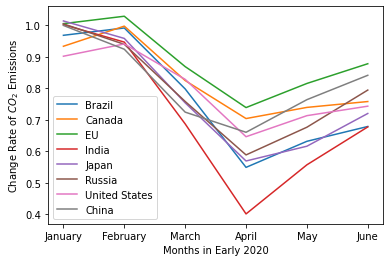

In [34]:
countries = ["Brazil", "Canada", "EU", "India", "Japan", "Russia", "United States", "China"]
fig, ax = plt.subplots(figsize=(6, 4))
early_year = ["January", "February", "March", "April", "May", "June"]
for country in countries:    
    ax.plot(early_year, change_rate[country], label = country)

ax.legend()
plt.ylabel("Change Rate of $CO_2$ Emissions")
plt.xlabel("Months in Early 2020")
plt.show()
fig.savefig("../../results/predictions/change_rate.pdf", bbox_inches='tight')

In [35]:
change_rate.to_csv('../../results/predictions/overall_vector.csv')